In [57]:
import re
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,  roc_curve, auc
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to C:\Users\PURVA
[nltk_data]     PUJARI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\PURVA
[nltk_data]     PUJARI\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('sentiment140.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [59]:
print("Unique value counts in the target column:")
print(df['target'].value_counts())

Unique value counts in the target column:
target
0    800000
4    800000
Name: count, dtype: int64


In [60]:
def clean_text(text):
    stopwordlist = [
        'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
        'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
        'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do',
        'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
        'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
        'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma',
        'me', 'more', 'most', 'my', 'myself', 'needn', 'no', 'nor', 'now',
        'o', 'of', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
        'out', 'own', 're', 's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such',
        't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
        'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
        'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
        'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre",
        "youve", 'your', 'yours', 'yourself', 'yourselves'
    ]

    
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    
    text = text.lower()
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub(r'@[\S]+', 'USER', text)
    text = re.sub(r'#(\S+)', r'\1', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = " ".join([word for word in text.split() if word not in stopwordlist])
    tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
    tokens = tokenizer.tokenize(text)

  
    pos_tags = nltk.pos_tag(tokens)

    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    
    return " ".join(lemmatized_tokens)

In [61]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)      
    text = re.sub(r"@\w+", "USER", text)     
    text = re.sub(r"[^a-zA-Z\s]", "", text)  
    text = text.lower()                     
    return text


In [70]:

df['target'] = df['target'].replace(4, 1)


df['text'] = df['text'].apply(clean_text)


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)


In [69]:
vectorizer = TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

In [64]:
def evaluate_model(model):
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_vect)[:, 1])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



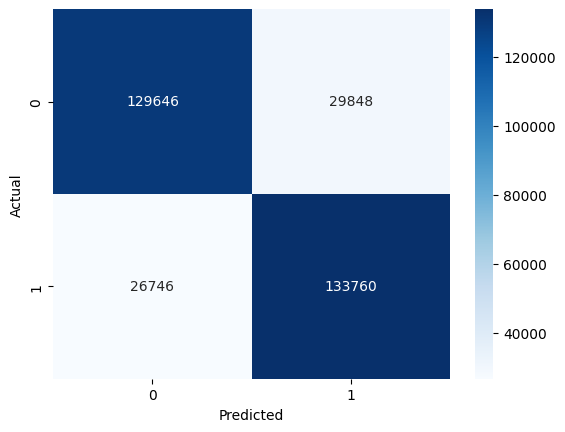

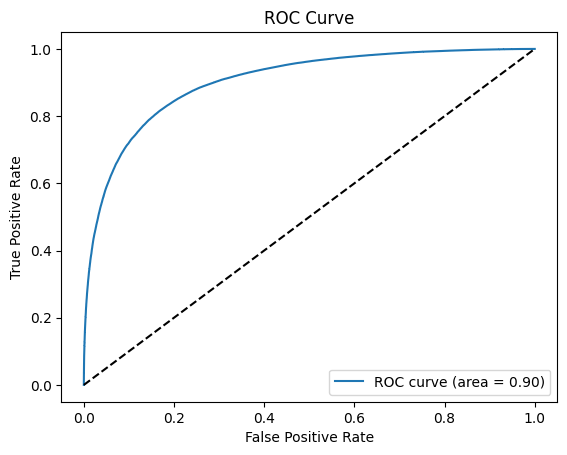

In [65]:
lr_model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
evaluate_model(lr_model)

In [66]:
st_tweet = ["I hate the lastest website design it is too boring!"]

test_tweet = [clean_text(st_tweet[0])]
vectorized_tweet = vectorizer.transform(test_tweet)

predicted_sentiment = lr_model.predict(vectorized_tweet)
proba = lr_model.predict_proba(vectorized_tweet)

print(f"Predicted Sentiment: {'Positive' if predicted_sentiment[0] == 1 else 'Negative'}")
print(f"Confidence Scores: {proba}")


Predicted Sentiment: Negative
Confidence Scores: [[0.88293359 0.11706641]]


In [67]:
st_tweet = ["I love rasam rice!"]

test_tweet = [clean_text(st_tweet[0])]
vectorized_tweet = vectorizer.transform(test_tweet)

predicted_sentiment = lr_model.predict(vectorized_tweet)
proba = lr_model.predict_proba(vectorized_tweet)

print(f"Predicted Sentiment: {'Positive' if predicted_sentiment[0] == 1 else 'Negative'}")
print(f"Confidence Scores: {proba}")


Predicted Sentiment: Positive
Confidence Scores: [[0.03304068 0.96695932]]


In [71]:
st_tweet = ["I am very happy and excited for the job!"]

test_tweet = [clean_text(st_tweet[0])]
vectorized_tweet = vectorizer.transform(test_tweet)

predicted_sentiment = lr_model.predict(vectorized_tweet)
proba = lr_model.predict_proba(vectorized_tweet)

print(f"Predicted Sentiment: {'Positive' if predicted_sentiment[0] == 1 else 'Negative'}")
print(f"Confidence Scores: {proba}")

Predicted Sentiment: Positive
Confidence Scores: [[0.00210793 0.99789207]]
